## Custom model on Vertex AI
This notebook shows how to build a custom model on Vertex AI and import the custom model using a custom container. We will compare the accuracy of this model against the one created using AutoML and BQML using ML pipelines (see pipeline notebook) to deploy the best model.

## Solution architecture
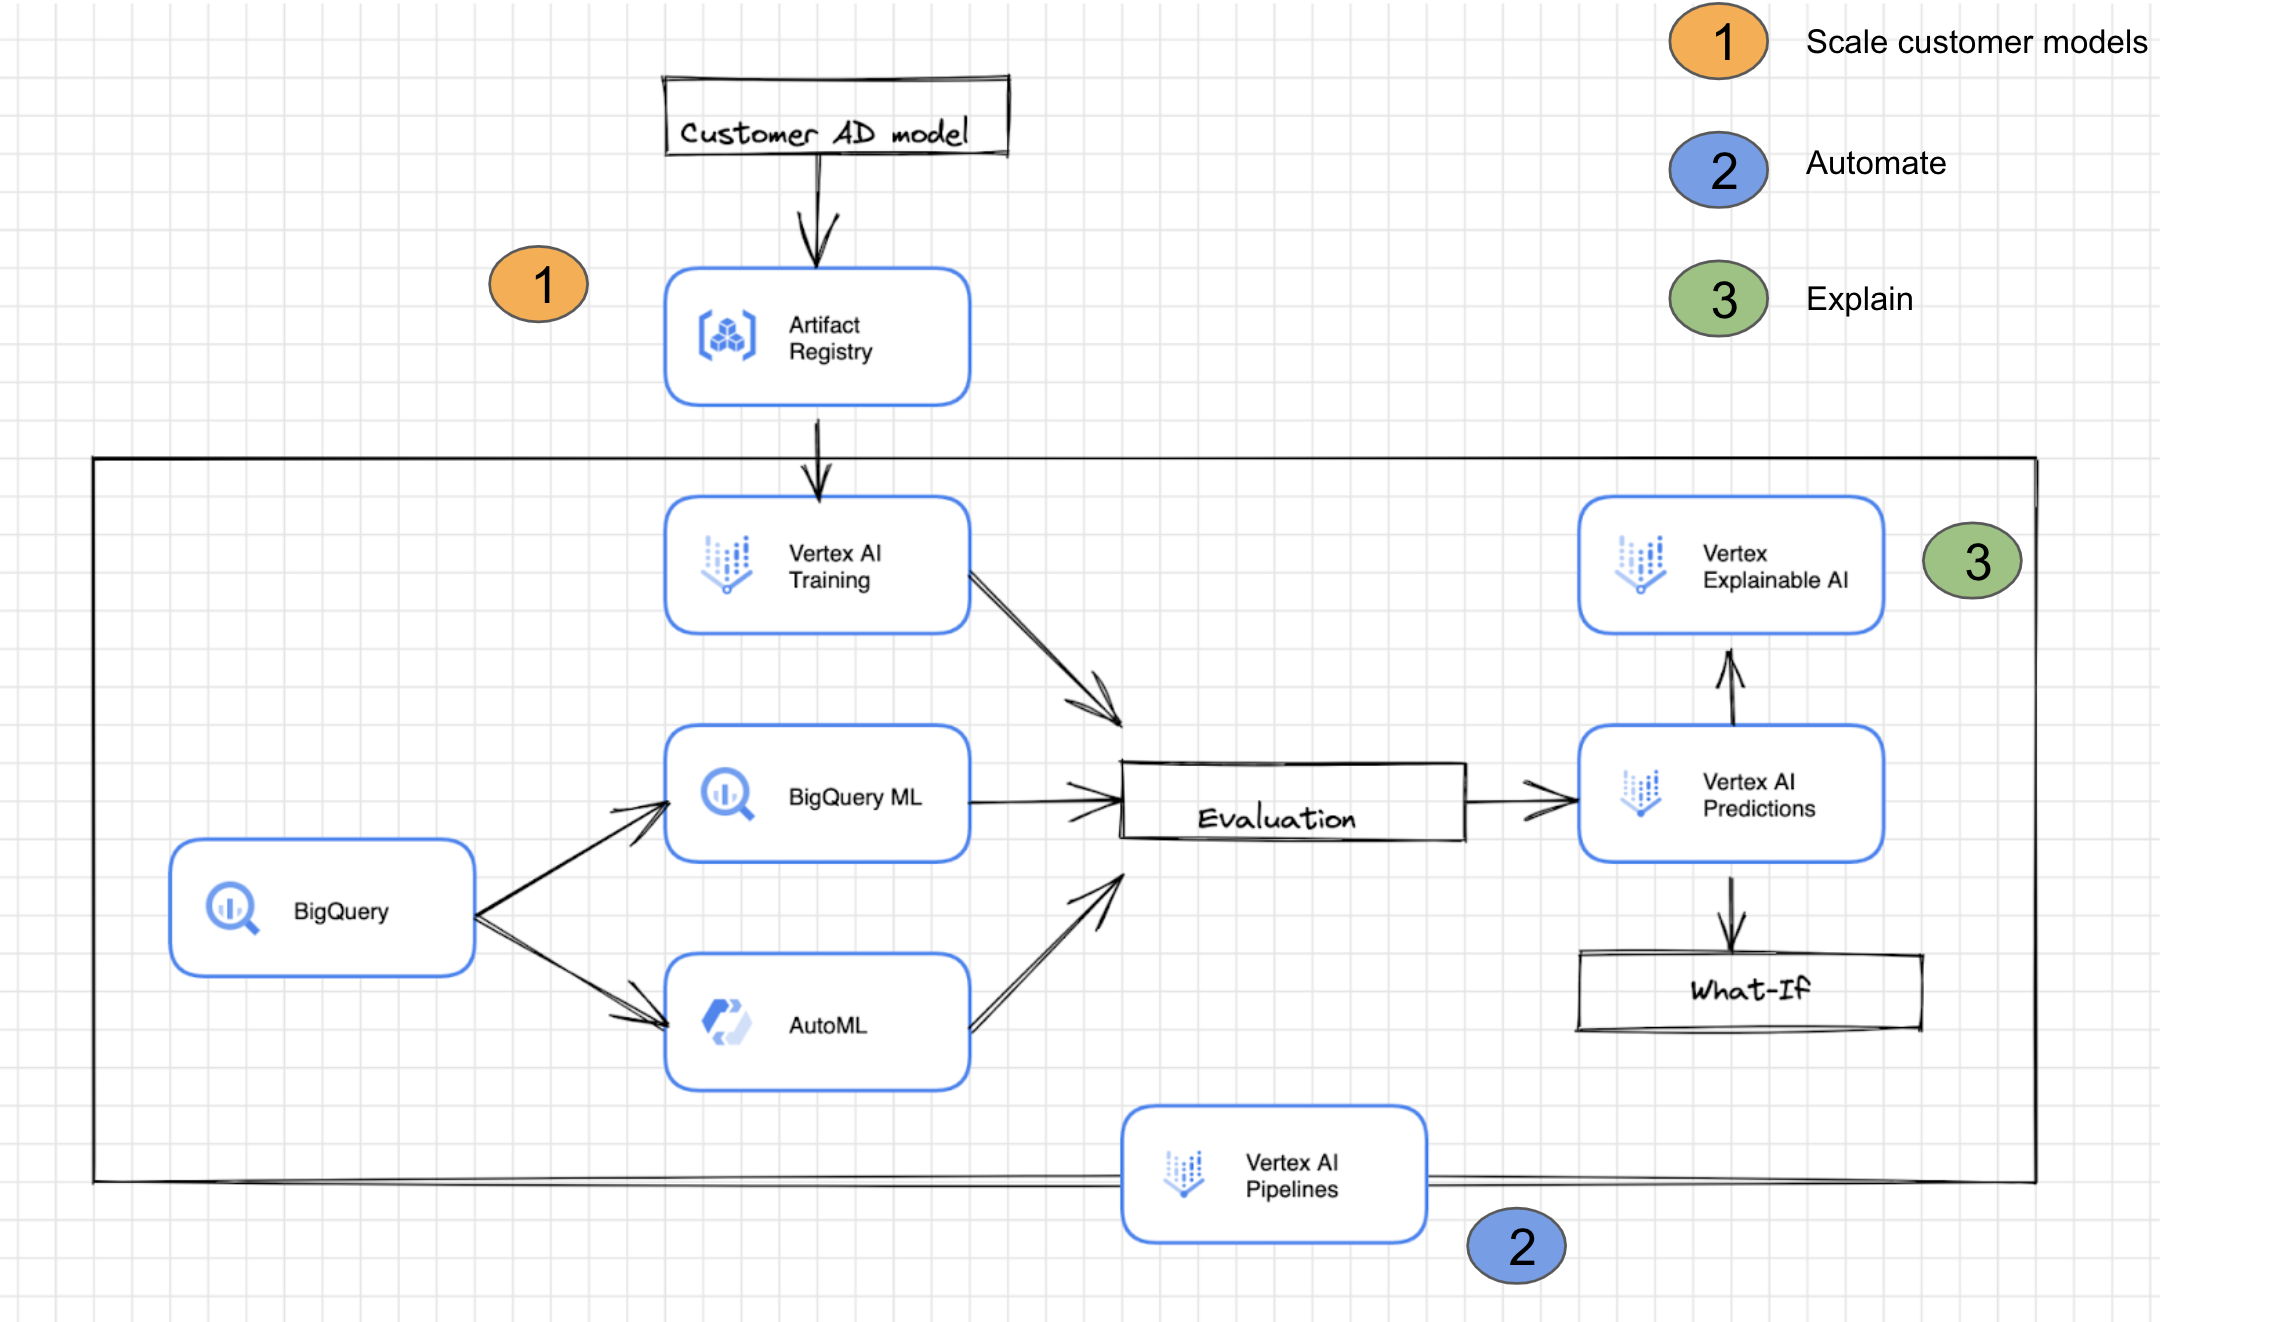

In [ ]:
import os

import google.auth

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if "default" in dir(google.auth):
    USER_FLAG = "--user"

In [1]:
#! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

In [3]:
PROJECT_ID = "experiment-megha"


Project ID:  experiment-megha


Otherwise, set your project ID here.

In [5]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [6]:
BUCKET_NAME = "demo-anomaly"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

In [10]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.cloud import storage
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [2]:
#pip install witwidget

In [12]:
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

In [13]:
# Load dataset
df = pd.read_csv(
    "gs://cloud-samples-data/vertex-ai/managed_notebooks/fraud_detection/fraud_detection_data.csv"
)

## Analyze the dataset
<a name="section-5"></a>


In [14]:
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Take a quick look at the dataset and the number of rows.

In [15]:
print("shape : ", df.shape)
df.head()

shape :  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Check for null values.

In [16]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Check the type of transactions involved.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0, 0.5, 'Amount')

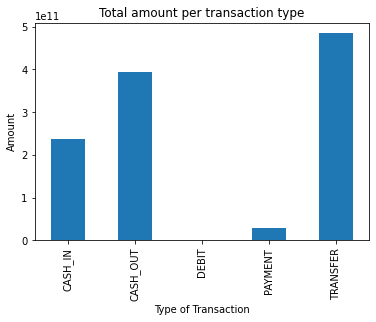

In [17]:
print(df.type.value_counts())
var = df.groupby("type").amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
var.plot(kind="bar")
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel("Type of Transaction")
ax1.set_ylabel("Amount")

## Working with imbalanced data

Althuogh the outcome variable "isFraud" seems to be very imbalanced in the current dataset, a base model can be trained on it to check the quality of fraudulent transactions in the data and if needed, counter measures like undersampling of majority class or oversampling of the minority class can be considered.

In [18]:
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

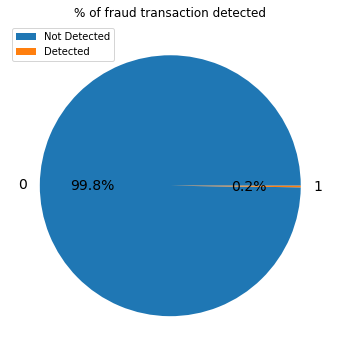

In [19]:
piedata = df.groupby(["isFlaggedFraud"]).sum()
f, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title("% of fraud transaction detected")
piedata.plot(
    kind="pie", y="isFraud", ax=axes, fontsize=14, shadow=False, autopct="%1.1f%%"
)
axes.set_ylabel("")
plt.legend(loc="upper left", labels=["Not Detected", "Detected"])
plt.show()

## Prepare data for modeling
To prepare the dataset for training, a few columns need to be dropped that contain either unique data ('nameOrig','nameDest') or redundant fields ('isFlaggedFraud'). The categorical field "type" which describes the type of transaction and is important for fraud detection needs to be one-hot encoded.


In [20]:
df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1, inplace=True)

In [21]:
X = pd.concat([df.drop("type", axis=1), pd.get_dummies(df["type"])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


Remove the outcome variable from the training data.

In [22]:
y = X[["isFraud"]]
X = X.drop(["isFraud"], axis=1)

Split the data and assign 70% for training and 30% for testing.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)
print(X_train.shape, X_test.shape)

(4453834, 11) (1908786, 11)


## Fit a random forest model
<a name="section-6"></a>

Fit a simple random forest classifier on the preprocessed training dataset.

In [27]:
%%time
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

CPU times: user 13min 36s, sys: 10.5 s, total: 13min 47s
Wall time: 13min 47s


RandomForestClassifier()

## Analyzing Results
<a name="section-7"></a>

The model returns good scores and the confusion matrix confirms that this model can indeed work with imbalanced data.

In [28]:
y_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

print("AUPRC :", (average_precision_score(y_test, y_prob[:, 1])))
print("F1 - score :", (f1_score(y_test, y_pred)))

print("Confusion_matrix : ")
print(confusion_matrix(y_test, y_pred))

print("classification_report")
print(classification_report(y_test, y_pred))

AUPRC : 0.925466434237081
F1 - score : 0.8503128911138924
Confusion_matrix : 
[[1904193      23]
 [   1173    3397]]
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       0.99      0.74      0.85      4570

    accuracy                           1.00   1908786
   macro avg       1.00      0.87      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



Use `RandomForestClassifier`'s `feature_importances_ function` to get a better understanding about which features were the most useful to the model.

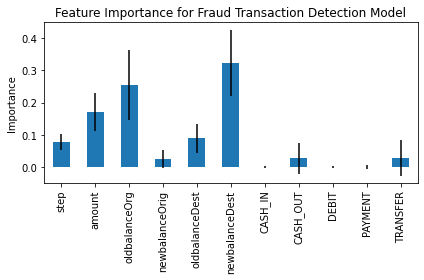

In [29]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()

## Save the model to a Cloud Storage path
<a name="section-8"></a>

In [30]:
# save the trained model to a local file "model.joblib"
FILE_NAME = "model.joblib"
joblib.dump(forest, FILE_NAME)

# Upload the saved model file to Cloud Storage
BLOB_PATH = "demo-anomaly"
BLOB_NAME = os.path.join(BLOB_PATH, FILE_NAME)

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Create a model in Vertex AI
<a name="section-9"></a>

In [31]:
MODEL_DISPLAY_NAME = "[your-model-display-name]"
ARTIFACT_GCS_PATH = f"{BUCKET_URI}/{BLOB_PATH}"

In [32]:
# Create a Vertex AI model resource
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/29437252490/locations/us-central1/models/5988683594728472576/operations/3026080918486908928
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/29437252490/locations/us-central1/models/5988683594728472576
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/29437252490/locations/us-central1/models/5988683594728472576')
[your-model-display-name]
projects/29437252490/locations/us-central1/models/5988683594728472576


## Create an Endpoint
<a name="section-10"></a>

In [33]:
ENDPOINT_DISPLAY_NAME = "[your-endpoint-display-name]"

In [34]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)


print(endpoint.display_name)
print(endpoint.resource_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/29437252490/locations/us-central1/endpoints/996043185555767296/operations/1006216485611241472
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/29437252490/locations/us-central1/endpoints/996043185555767296
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/29437252490/locations/us-central1/endpoints/996043185555767296')
[your-endpoint-display-name]
projects/29437252490/locations/us-central1/endpoints/996043185555767296


### Deploy the model to the created Endpoint

Configure the deployment name, machine type, and other parameters for the deployment.

In [37]:
DEPLOYED_MODEL_NAME = "anomaly_fraud_endpoint"
MACHINE_TYPE = "n1-standard-2"

In [38]:
# Uncomment if starting over without model and endpoint references
# model = aiplatform.Model('[your-model-resource-name]')
# endpoint = aiplatform.Endpoint('[your-endpoint-resource-name]')

# deploy the model to the endpoint
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/29437252490/locations/us-central1/endpoints/996043185555767296
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/29437252490/locations/us-central1/endpoints/996043185555767296/operations/8606040856798953472
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/29437252490/locations/us-central1/endpoints/996043185555767296
[your-model-display-name]
projects/29437252490/locations/us-central1/models/5988683594728472576


Save the ID of the deployed model. The ID of the deployed model can also be checked by using the `endpoint.list_models()` method.

In [24]:
DEPLOYED_MODEL_ID = "996043185555767296"

## What-If Tool 
<a name="section-11"></a>

The What-If Tool can be used to analyze the model predictions on a test data. See a [brief introduction to the What-If Tool](https://pair-code.github.io/what-if-tool/). In this tutorial, the What-If Tool will be configured and run on the model trained locally, and on the model deployed on Vertex AI Endpoints in the previous steps.

[WitConfigBuilder](https://github.com/PAIR-code/what-if-tool/blob/master/witwidget/notebook/visualization.py#L30) provides the  `set_ai_platform_model()` method to configure the What-If Tool with a model deployed as a version on Ai Platform models. This feature currently supports Ai Platform only but not Vertex AI models. Fortunately, there is also an option to pass a custom function for generating predictions through the `set_custom_predict_fn()` method where either the locally trained model or a function that returns predictions from a Vertex AI model can be passed.

### Prepare test samples

Save some samples from the test data for both the available classes (Fraud/not-Fraud) to analyze the model using the What-If Tool.

In [25]:
# collect 50 samples for each class-label from the test data
pos_samples = y_test[y_test["isFraud"] == 1].sample(50).index
neg_samples = y_test[y_test["isFraud"] == 0].sample(50).index
test_samples_y = pd.concat([y_test.loc[pos_samples], y_test.loc[neg_samples]])
test_samples_X = X_test.loc[test_samples_y.index].copy()

### Running the What-If Tool on the local model

In [3]:
# define target and labels
TARGET_FEATURE = "isFraud"
LABEL_VOCAB = ["not-fraud", "fraud"]

# define the function to adjust the predictions


def adjust_prediction(pred):
    return [1 - pred, pred]


# Combine the features and labels into one array for the What-If Tool
test_examples = np.hstack(
    (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
)

# Configure the WIT to run on the locally trained model
config_builder = (
    WitConfigBuilder(
        test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
    )
    .set_custom_predict_fn(forest.predict_proba)
    .set_target_feature(TARGET_FEATURE)
    .set_label_vocab(LABEL_VOCAB)
)

# display the WIT widget
WitWidget(config_builder, height=600)

### Running the What-If Tool on the deployed Vertex AI model

In [28]:
# configure the target and class-labels
TARGET_FEATURE = "isFraud"
LABEL_VOCAB = ["not-fraud", "fraud"]

# function to return predictions from the deployed Model


def endpoint_predict_sample(instances: list):
    prediction = endpoint.predict(instances=instances)
    preds = [[1 - i, i] for i in prediction.predictions]
    return preds


# Combine the features and labels into one array for the What-If Tool
test_examples = np.hstack(
    (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
)

# Configure the WIT with the prediction function
config_builder = (
    WitConfigBuilder(
        test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
    )
    .set_custom_predict_fn(endpoint_predict_sample)
    .set_target_feature(TARGET_FEATURE)
    .set_label_vocab(LABEL_VOCAB)
)

# run the WIT-widget
WitWidget(config_builder, height=400)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

In [31]:
DEPLOYED_MODEL_ID = "398190335022333952"

## Clean up
<a name="section-12"></a>


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# undeploy the model
endpoint.undeploy(deployed_model_id=DEPLOYED_MODEL_ID)

In [ ]:
# delete the endpoint
endpoint.delete()

In [ ]:
# delete the model
model.delete()

In [ ]:
# uncomment to remove the contents of the Cloud Storage bucket
# ! gsutil -m rm -r $BUCKET_NAME